In [1]:
import sys, os, platform, inspect

def get_current_file_path():
    # script filename (usually with path)
    filename = inspect.getfile(inspect.currentframe())
    # script directory
    path = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
    return filename, path


if platform.system() == 'Linux': # Colab setting
    from google.colab import drive
    drive.mount('/content/gdrive')
    path = '/content/gdrive/My Drive/Colab Notebooks/kaggle'
else:
    _, path = get_current_file_path()    

sys.path.insert(0, path)
os.chdir(path)

sys.path.append(path + '/t-SNE')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
transform = transforms.ToTensor()
dset_train = torchvision.datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
dset_test = torchvision.datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

factor = 0.9
train_len = int(len(dset_train) * factor)
valid_len = len(dset_train)  - train_len

dset_train, dset_valid = data.random_split(dset_train, [train_len, valid_len])

batch_size = 16

dloader_train = data.DataLoader(dset_train, batch_size=batch_size, shuffle=True)
dloader_valid = data.DataLoader(dset_valid, batch_size=batch_size, shuffle=True)

tensor([9, 1, 6, 7, 3, 3, 7, 1, 6, 3, 5, 1, 4, 4, 9, 1])


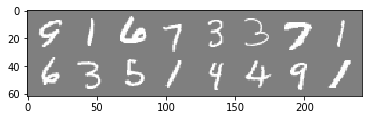

In [4]:
x, y = next(iter(dloader_train))
plt.imshow((torchvision.utils.make_grid(x).numpy().transpose(1, 2, 0)+1)/2, cmap='gray')
print(y)

In [0]:
Encoder = lambda: nn.Sequential(
    conv2d_layer(1, 16),
    conv2d_layer(16, 32), 
    nn.MaxPool2d(2),
    conv2d_layer(32, 64), 
    nn.MaxPool2d(2),
    conv2d_layer(64, 128, padding=0),
    nn.Conv2d(128, 256, 2, stride=2),
#    nn.AvgPool2d(2)
)

Decoder = lambda: nn.Sequential(
    nn.ConvTranspose2d(256, 128, 2, stride=2),
    nn.ConvTranspose2d(128, 64, 2, stride=2),
    nn.ConvTranspose2d(64, 32, 2, stride=2),
    nn.ConvTranspose2d(32, 16, 2, stride=2),
    nn.Conv2d(16, 1, 5)
)

Classifier = lambda: nn.Sequential(
    nn.Linear(256 * 2**2, 128),
    nn.LeakyReLU(0.1), nn.Dropout(.25),
    nn.Linear(128, 10)
)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.classifier = Classifier()

    def forward_AE(self, x):
        return self.decoder(self.encoder(x))

    def forward_CL(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [0]:
class Save:
    def __init__(self, save_name):
        self.ℓ_min = np.inf
        self.save_name = save_name

    def __call__(self, ℓ, model, verbose=True):
        if ℓ < self.ℓ_min:
            self.ℓ_min = ℓ
            if verbose:
                print(f' ==> saving model')
            torch.save(model.state_dict(), f'{save_name}.pt')

def conv2d_layer(c_in, c_out, k=3, padding=1, bn=True, relu=nn.ReLU()):
    seq = [nn.Conv2d(c_in, c_out, k, padding=padding), relu]
    if bn:
        seq.append(nn.BatchNorm2d(c_out))
    return(nn.Sequential(*seq))

def train(model, epochs, ℓ_fn_AE, ℓ_fn_CL, optimizer,
          dloader_train, dloader_valid, device, save_name='model'):
    save_model = Save(save_name)
    for i_epoch in range(1, epochs+1):
        for x, y in dloader_train:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            ℓ_AE = ℓ_fn_AE(model.forward_AE(x), x)
            ℓ_CL = ℓ_fn_CL(model.forward_CL(x), y)
            ℓ = ℓ_AE + ℓ_CL
            ℓ.backward()                        
            optimizer.step()
        model.eval()
        loss_val_CL, loss_val_AE = [], []
        loss_acc = []    # accuracy only for Classifier
        for x, y in dloader_valid:
            x, y = x.to(device), y.to(device)
            # classifier part
            ŷ = model.forward_CL(x)
            ℓ_CL = ℓ_fn_CL(ŷ, y)
            loss_val_CL.append(ℓ_CL.cpu().item())
            loss_acc.append((y == ŷ.argmax(dim=1)).to(torch.float).mean())
            # AE part
            x̂ = model.forward_AE(x)
            ℓ_AE = ℓ_fn_AE(x̂, x)/torch.norm(x)
            loss_val_AE.append(ℓ_AE.cpu().item())
        model.train()
        print(f'Epoch {i_epoch} CL_loss: {sum(loss_val_CL)/len(loss_val_CL):.5f}, accuracy_CL: {sum(loss_acc)/len(loss_acc):.5f}, AE_loss: {sum(loss_val_AE)/len(loss_val_AE):.5f}')

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)
print(model)
lr = 0.0015
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, 20, nn.MSELoss(), nn.CrossEntropyLoss(), optimizer, dloader_train, dloader_valid, device)

Model(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)
print(model)
lr = 0.0015
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, 20, nn.MSELoss(), nn.CrossEntropyLoss(), optimizer, dloader_train, dloader_valid, device)

Model(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T